In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


In [ ]:
import torch 
assert torch.cuda.is_available(), "GPU not available"

In [ ]:
#chargement du jeu de donnees
wine_dataframe = pd.read_csv('datatest (1).csv', index_col=0)
wine_dataframe = wine_dataframe.drop('URLS', axis=1)
wine_dataframe = wine_dataframe.drop('Tranquille to Mousseux', axis=1)

wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].str.replace(';', '')
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].str.replace(';', '')
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].str.replace(';', '')
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].str.replace(';', '')
wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].astype(float)
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].astype(float)
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].astype(float)
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].astype(float)


In [ ]:
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('/+', '+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace(',+', '+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('/+', '+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace(',+', '+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã©', 'é')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã‰', 'é')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã©', 'é')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã‰', 'é')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lower()
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lower()
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lstrip('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lstrip('+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.split('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.split('+')

wine_dataframe['Aromas'] = wine_dataframe['Aromas'].apply(lambda x: [] if isinstance(x, float) else x)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].apply(lambda x: [] if isinstance(x, float) else x)
print(wine_dataframe.describe())

<ipython-input-24-2b05902bc529>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('/+', '+')
<ipython-input-24-2b05902bc529>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace(',+', '+')
<ipython-input-24-2b05902bc529>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('/+', '+')
<ipython-input-24-2b05902bc529>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace(',+', '+')


       Léger to Puissant  Souple to Tannique  Sec to Moelleux  Doux to Acide
count       35218.000000        35218.000000     35218.000000   35218.000000
mean           39.965001           19.491293        19.386413      37.882006
std            29.311771           23.718340        15.306354      28.274971
min             0.000000            0.000000         0.000000       0.000000
25%             0.000000            0.000000         0.000000       0.000000
50%            51.000000            0.000000        23.578555      50.105424
75%            63.804147           40.940347        30.224412      59.500000
max            85.000000           85.000000        85.000000      85.000000


In [ ]:
value_counts = wine_dataframe['Olphactive'].apply(lambda x: type(x).__name__).value_counts()
print(value_counts)

list    35218
Name: Olphactive, dtype: int64


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
Aromas_one_hot_encoded = mlb.fit_transform(wine_dataframe['Aromas'])
Aromas_df_encoded = pd.DataFrame(Aromas_one_hot_encoded, columns=mlb.classes_)
Olphactive_one_hot_encoded = mlb.fit_transform(wine_dataframe['Olphactive'])
Olphactive_df_encoded = pd.DataFrame(Olphactive_one_hot_encoded, columns=mlb.classes_)
df_concatenated_0 = pd.concat([wine_dataframe, Aromas_df_encoded], axis=1)
df_concatenated = pd.concat([df_concatenated_0, Olphactive_df_encoded], axis=1)

df_concatenated.drop('Aromas', axis=1, inplace=True)
df_concatenated.drop('Olphactive', axis=1, inplace=True)

# count the number of observations per variety
counts = df_concatenated['Cépages'].value_counts()

# print the counts
print(counts)

Pinot noir            8378
Cabernet-Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: Cépages, dtype: int64


In [ ]:
for i, row in df_concatenated.iterrows():
    if row['Léger to Puissant'] == 0 and row['Souple to Tannique'] == 0 and row['Sec to Moelleux'] == 0 and row['Doux to Acide'] == 0:
        df_concatenated = df_concatenated.drop(i) 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df_concatenated['Cépages'].value_counts()


Pinot noir            5888
Chardonnay            5633
Cabernet-Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: Cépages, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = df_concatenated.drop('Cépages', axis=1)
y = df_concatenated['Cépages']
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
print(X_train.shape); print(X_test.shape)

(21553, 679)
(2395, 679)


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train.shape); print(X_test.shape)

(21553, 679)
(2395, 679)


# 2) PREDICT

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['logistic', 'relu','tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}
from sklearn.model_selection import GridSearchCV

In [ ]:
mlp = MLPClassifier(alpha = 0.05 , learning_rate = 'adaptive' , hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=500)
print("hello")
mlp.fit(X_train,y_train)
print("hi")
y_pred = mlp.predict(X_test)

hello
hi


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Cabernet-Sauvignon       0.88      0.91      0.90       439
        Chardonnay       0.96      0.97      0.97       595
            Malbec       0.82      0.76      0.79       127
            Merlot       0.86      0.85      0.86       233
        Pinot noir       0.96      0.93      0.94       580
          Riesling       0.93      0.96      0.94       258
        Sangiovese       0.75      0.78      0.76        80
         Zinfandel       0.86      0.86      0.86        83

          accuracy                           0.92      2395
         macro avg       0.88      0.88      0.88      2395
      weighted avg       0.92      0.92      0.92      2395



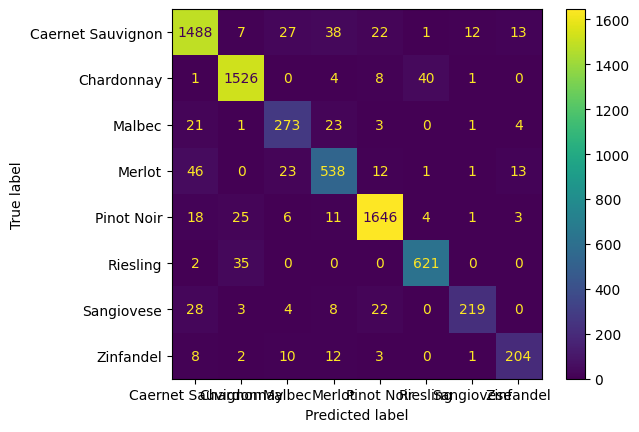

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Caernet Sauvignon" , "Chardonnay","Malbec","Merlot","Pinot Noir","Riesling","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,),(500,),(679,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, verbose = 4, n_jobs=-1, cv=5)
clf.fit(X_train,y_train) # X is train samples and y is the corresponding labels

/opt/tljh/user/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50,), (500,), (679,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
